Exploratory Data Analysis (EDA)

Now that I've have completed an initial cleaning of the data, it's time to explore what data we are looking at.
During my EDA, I will take a look at what data is missing and how to deal with that. I will decide on my dependent variable, and explore its correlation to the features.

In [1]:
# importing packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Downloading cvs files
housing = pd.read_csv('../capstone2-housing/rawdata/cleaned_data.csv', index_col=0)
data_dict = pd.read_csv('../capstone2-housing/documents/data_dictionary.csv')

In [3]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Let's start with deciding on a dependent variable. Since all final closing prices are available, and my goal with this project is to build a model to predict final closing prices, it seems most prudent to start looking at using the column SalePrice as the dependent variable. Let's start with taking a closer look at the column.

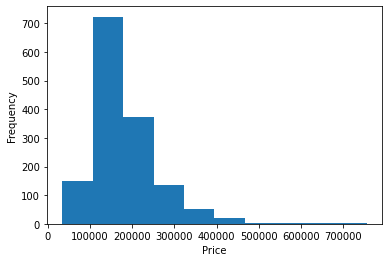

In [4]:
_ = plt.hist(housing['SalePrice'])
_ = plt.xlabel("Price")
_ = plt.ylabel("Frequency")

In [5]:
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Looks like the final SalePrice in Iowa is a continuous value that ranges between 34900 and 755000. Has a mean of 180921.2 and a standard deviation of 79442.5. So I will be moving forward with SalePrice as my dependent variable.

Now, before doing anything else, let's take a look at the missing values I identified during Data Wrangling and decide what to do with them.

In [6]:
# Count and percentage of missing data in columns
missing = pd.concat([housing.isnull().sum(), 100 * housing.isnull().mean().round(4)], axis=1)
missing.columns=['count', '%']
missing_values = missing.sort_values(by=['count', '%'], ascending=False)
cols_missing = missing_values.loc[missing_values['count'] != 0.00]
cols_missing

,count,%
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


It turns out that 99.52% of the properties in this sample, do not have pools. Could pools be a big influence on the price of a house? 

In [7]:
row = data_dict[data_dict['Name'] == 'PoolQC']
print(row.to_json())

{"Unnamed: 0":{"71":71},"Name":{"71":"PoolQC"},"Description":{"71":"Pool quality"},"Notes":{"71":"       Ex:Excellent       Gd:Good       TA:Average\/Typical       Fa:Fair       NA:No Pool"}}


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,YrMoSold
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Normal,208500,2008-02-01
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Normal,181500,2007-05-01
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Normal,223500,2008-09-01
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Abnorml,140000,2006-02-01
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Normal,250000,2008-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Normal,175000,2007-08-01
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,WD,Normal,210000,2010-02-01
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,WD,Normal,266500,2010-05-01
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,WD,Normal,142125,2010-04-01
